In [1]:
import ee, geemap,datetime
import geopandas as gpd
import pandas as pd
import scripts

%load_ext autoreload
%autoreload 2

ee.Initialize()

c:\Users\ermolaevNR\.conda\envs\GIS38\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

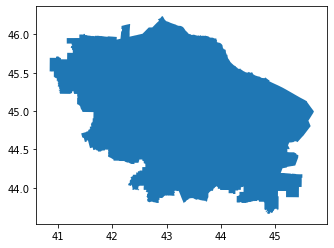

In [5]:
region_boundary = gpd.read_file('data/vector_data_stavropol.gpkg', layer='region_boundary')
region_boundary.plot()

In [18]:
def S2masking(image): 
    cloudProb = image.select('MSK_CLDPRB')  # покрытие облаками
    snowProb = image.select('MSK_SNWPRB') # покрытие снегом
    cloud = cloudProb.lt(1) # создали бинарную маску иными словами просто все что имеет значение меньше 5 одна группа выше другая
                        # а мы помним что пиксели принимают значения от 0 до 255
    snow = snowProb.lt(1) # тоже самое что с облаками
    scl = image.select('SCL') # слой с классификатором(есть в sentinel 2 уровня обработки 2А)
    shadow = scl.neq(3);# 3 в классификации это тени от облаков
    cirrus_medium = scl.neq(8) # тоже по классификации облака 
    cirrus_high = scl.neq(9) # аналогично облака
    cirrus = scl.neq(10); # 10 это перистые облака или цирусы
    return  image.updateMask(cirrus).updateMask(cirrus_medium).updateMask(cirrus_high)

    

In [19]:
row_image = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterDate('2022-05-01', '2022-10-01') \
                .filterBounds(geemap.geopandas_to_ee(region_boundary)) \
                .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 10) \
                .map(S2masking) \
                .select(['B4','B3','B2', 'B8']) \
                .median() \
                .clip(geemap.geopandas_to_ee(region_boundary))


In [29]:
row_image = row_image.unmask()

In [30]:
geemap.ee_export_image_to_drive(
    row_image, description='sentinel_2_stav', folder='export', region=geemap.geopandas_to_ee(region_boundary), scale=10
)

Exporting sentinel_2_stav ...


In [2]:
district = gpd.read_file('data/vector_data_stavropol.gpkg', layer='disctrict_boundary')

c:\Users\ermolaevNR\.conda\envs\GIS38\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
test_region = district[district.NAME_EN == "Georgiyevsky District"]

In [4]:
georgy_district_raster =  scripts.get_raster_data.SEN2_downloader('2022' ,test_region)

In [5]:
data = georgy_district_raster.get_collection()

In [6]:
georgy_district_raster.get_rgb_nir()

In [7]:
georgy_district_raster.rgb_nir

In [8]:
visualization = {"bands": ['B4', 'B3', 'B2']}

In [9]:
map = geemap.Map()

In [10]:
map.addLayer(georgy_district_raster.rgb_nir, visualization , "RGB")

In [11]:
map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…